## Code to Compare ECMWF and Met Office Wind Data

The data in question is a small subset of the 10m wind available; we are exploring the behaviour seen around the AGAGE data collection site on the west coast of Ireland (Mace Head) in January-June 2015.

In [23]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from windrose import WindroseAxes
import numpy as np

import sys
sys.path.append('../')
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'meteorological_data'

In [2]:
# MHD latitude and longitude - 53.3267° N, 9.9046° W
site_latitude = 53.3267
site_longitude = -9.9046

### Extracting Data

#### ECMWF

In [4]:
# extracting ECMWF data (covering area around MHD)
# extracting only the first 6 months of 2015
ecmwf_ds = xr.open_mfdataset(sorted((data_path/'ECMWF'/'MHD'/'single_levels').glob('single_level_2015_*.nc'))[:6])
ecmwf_df = ecmwf_ds.to_dataframe()

# interpolating data to as close to MHD as possible
interpolated_data = ecmwf_df.interpolate(method='linear', limit_direction='both', limit_area='inside')

tolerance = 0.1

# extracting u and v components of wind for MHD
ecmwf_mhd = interpolated_data[
    (interpolated_data.index.get_level_values('latitude') >= site_latitude - tolerance) &
    (interpolated_data.index.get_level_values('latitude') <= site_latitude + tolerance) &
    (interpolated_data.index.get_level_values('longitude') >= site_longitude - tolerance) &
    (interpolated_data.index.get_level_values('longitude') <= site_longitude + tolerance)
]

print(f"Interpolated Latitude = {ecmwf_mhd.index.get_level_values('latitude').values[0]:.4f}")
print(f"Interpolated Longitude = {ecmwf_mhd.index.get_level_values('longitude').values[0]:.4f}")

# dropping latitude and longitude index levels, not needed now narrowed down to only MHD
ecmwf_mhd = ecmwf_mhd.droplevel(['latitude', 'longitude'])

# resampling for 6 hourly readings, allows for easier comparison of datasets
resampled_ecmwf_mhd = ecmwf_mhd.resample('6H').mean()

Interpolated Latitude = 53.3270
Interpolated Longitude = -9.9045


In [5]:
# calculating wind speed and direction from u and v components
ecmwf_u = resampled_ecmwf_mhd['u10']
ecmwf_v = resampled_ecmwf_mhd['v10']

ecmwf_wind_speed = np.sqrt(ecmwf_u**2 + ecmwf_v**2)
ecmwf_wind_direction = (np.arctan2(ecmwf_u, ecmwf_v) * 180 / np.pi) + 180

#### Met Office Data

In [6]:
# extracting Met Office data for January-June 2015
met_ds = xr.open_mfdataset((data_path/"MetOffice").glob("*.nc"))

# dropping variables that are not needed
variables_to_drop = ['Temperature', 'PBLH', 'Pressure', 'Sea_level_pressure']
met_ds = met_ds.drop_vars(variables_to_drop)

met_df = met_ds.to_dataframe()

# interpolating data to as close to MHD as possible using same method as above
interpolated_data = met_df.interpolate(method='linear', limit_direction='both', limit_area='inside')

tolerance = 0.1

met_mhd = interpolated_data[
    (interpolated_data.index.get_level_values('lat') >= site_latitude - tolerance) &
    (interpolated_data.index.get_level_values('lat') <= site_latitude + tolerance) &
    (interpolated_data.index.get_level_values('lon') >= site_longitude - tolerance) &
    (interpolated_data.index.get_level_values('lon') <= site_longitude + tolerance)
]

print(f"Interpolated Latitude = {met_mhd.index.get_level_values('lat').values[0]:.4f}")
print(f"Interpolated Longitude = {met_mhd.index.get_level_values('lon').values[0]:.4f}")

met_mhd = met_mhd.droplevel(['lat', 'lon'])

resampled_met_mhd = met_mhd.resample('6H').mean()

Interpolated Latitude = 53.3170
Interpolated Longitude = -9.9000


### January - June 2015

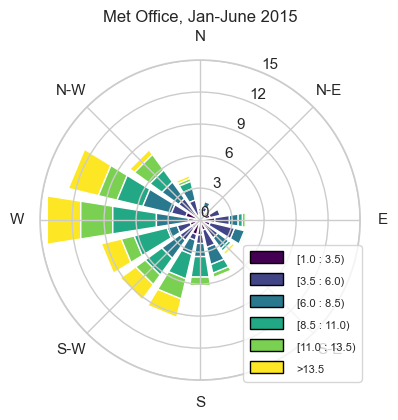

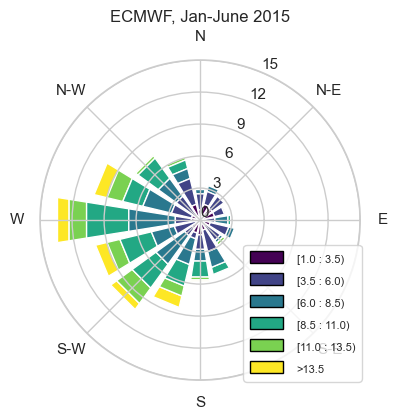

In [8]:
# Windrose plots
sns.set(style='whitegrid')
sns.set_palette("colorblind")

bins_range = np.arange(1,16,2.5)

fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(resampled_met_mhd["Wind_Direction"], resampled_met_mhd["Wind_Speed"], 
       normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis, bins=bins_range)
ax.set_legend(loc=4, fontsize=12)
ax.set_yticks(np.arange(0, 16, step=3))
ax.set_yticklabels(np.arange(0, 16, step=3))
ax.set_title("Met Office, Jan-June 2015")
plt.show()

fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(ecmwf_wind_direction, ecmwf_wind_speed, normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis, bins=bins_range)
ax.set_legend(loc=4, fontsize=12)
ax.set_yticks(np.arange(0, 16, step=3))
ax.set_yticklabels(np.arange(0, 16, step=3))
ax.set_title("ECMWF, Jan-June 2015")
plt.show()

Text(0.5, 0.98, 'Comparing ECMWF and Met Office Data, January-June 2015 at Mace Head, Ireland')

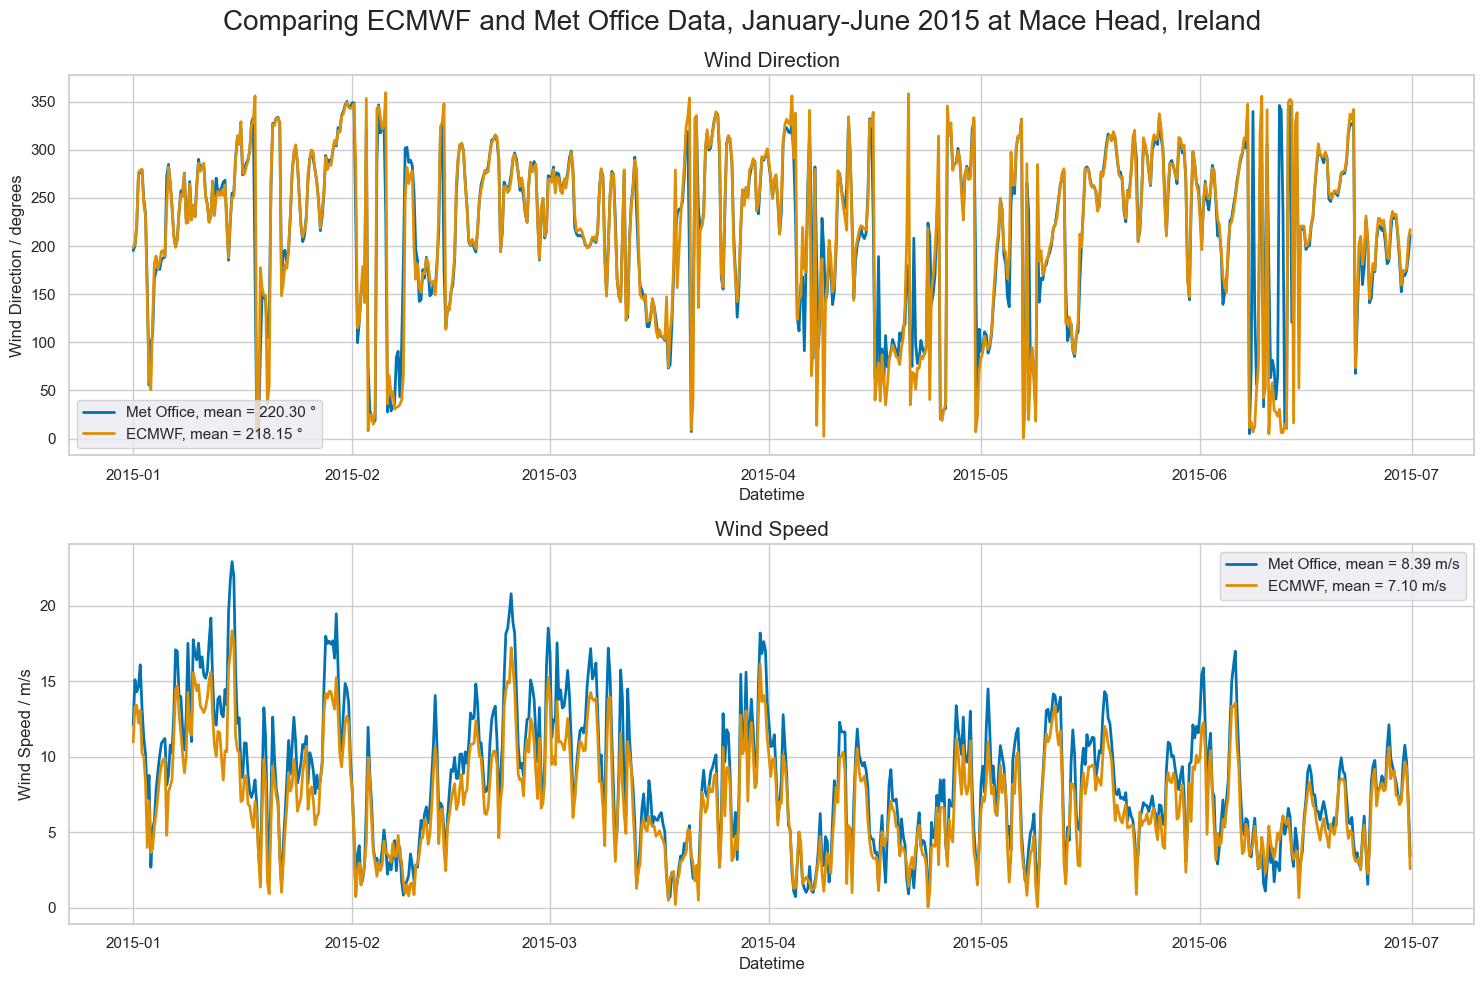

In [9]:
# plotting wind speeds and direction against time
fig, axs = plt.subplots(2,1, figsize=(15,10))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# plotting wind direction
axs[0].plot(resampled_met_mhd.index.get_level_values('time').values, resampled_met_mhd["Wind_Direction"].values,
           label=(f"Met Office, mean = {resampled_met_mhd['Wind_Direction'].values.mean():.2f} °"),
           linewidth=2)

axs[0].plot(ecmwf_wind_direction.index.values, ecmwf_wind_direction,
           label=(f"ECMWF, mean = {ecmwf_wind_direction.mean():.2f} °"),
           linewidth=2)

axs[0].set_xlabel("Datetime")
axs[0].set_ylabel("Wind Direction / degrees")
axs[0].legend()
axs[0].set_title("Wind Direction", fontsize=15)

# plotting wind speed
axs[1].plot(resampled_met_mhd.index.get_level_values('time').values, resampled_met_mhd["Wind_Speed"].values,
           label=(f"Met Office, mean = {resampled_met_mhd['Wind_Speed'].values.mean():.2f} m/s"),
           linewidth=2)

axs[1].plot(ecmwf_wind_speed.index.values, ecmwf_wind_speed,
           label=(f"ECMWF, mean = {ecmwf_wind_speed.mean():.2f} m/s"),
           linewidth=2)

axs[1].set_xlabel("Datetime")
axs[1].set_ylabel("Wind Speed / m/s")
axs[1].legend()
axs[1].set_title("Wind Speed", fontsize=15)

fig.set_tight_layout(True)
fig.suptitle("Comparing ECMWF and Met Office Data, January-June 2015 at Mace Head, Ireland", fontsize=20)

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


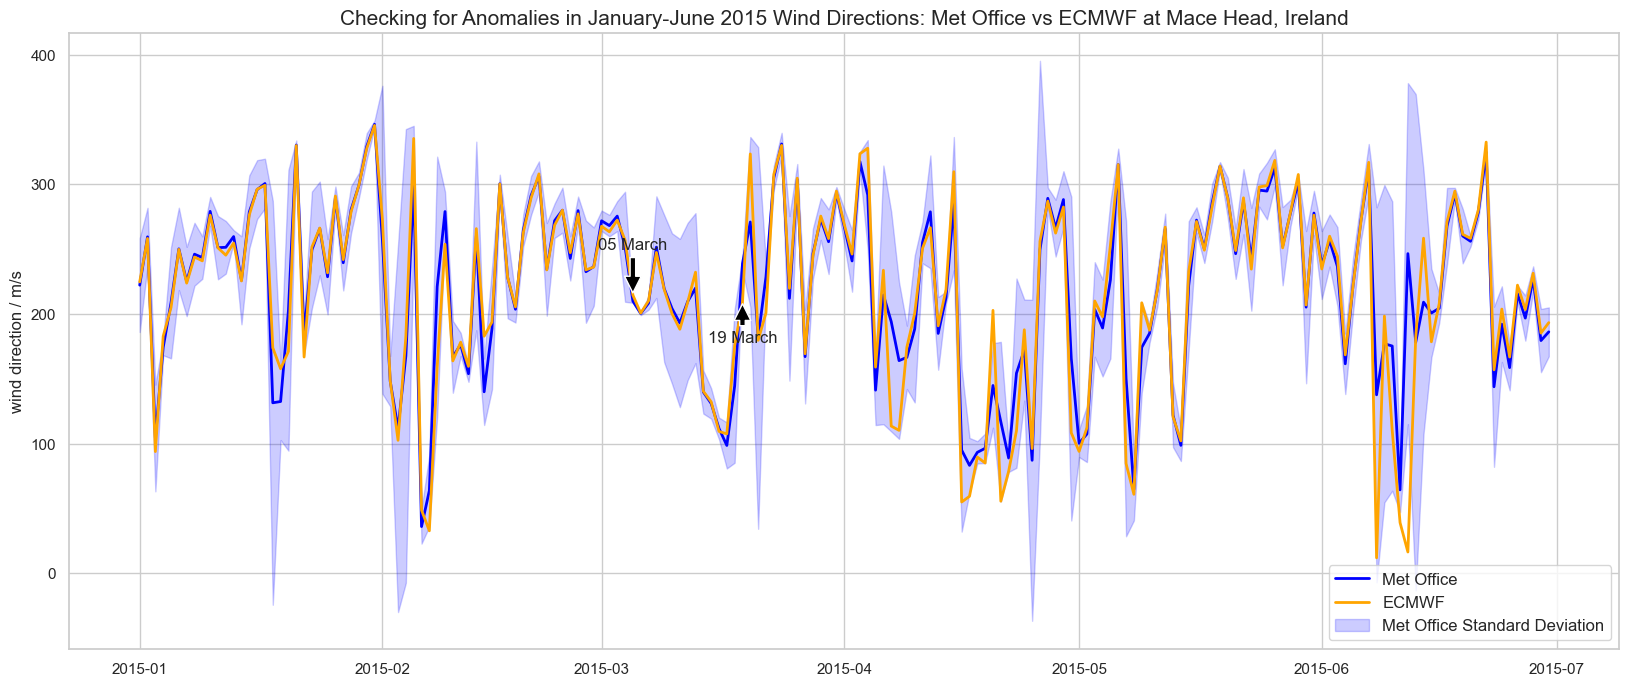

In [12]:
# Investing direction further - identifying anomalies
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='whitegrid')
sns.set_palette("colorblind")

# calculating daily averages
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Direction"].mean().reset_index()
met_daily.set_index('time', inplace=True)
met_daily.index = met_daily.index.to_timestamp()

ecmwf_daily = ecmwf_wind_direction.groupby(ecmwf_wind_direction.index.to_period('D')).mean().reset_index()
ecmwf_daily.set_index('time', inplace=True)

ax.plot(met_daily.index.get_level_values('time').values, met_daily["Wind_Direction"].values,
           label=(f"Met Office"), linewidth=2, color='blue')
ax.plot(ecmwf_daily.index.values, ecmwf_daily,
           label=(f"ECMWF"), linewidth=2, color='orange')

# calculating standard deviation
std_met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Direction"].std().reset_index()
std_met_daily.set_index('time', inplace=True)
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Direction"].mean().reset_index()
met_daily.set_index('time', inplace=True)


# adding standard deviation shading
upper_met = met_daily["Wind_Direction"] + std_met_daily["Wind_Direction"]
lower_met = met_daily["Wind_Direction"] - std_met_daily["Wind_Direction"]
ax.fill_between(met_daily.index, lower_met, upper_met, color='blue', alpha=0.2, label="Met Office Standard Deviation")


# adding tolerance range based on 3 standard deviations
upper_range = met_daily["Wind_Direction"] + 3*(std_met_daily['Wind_Direction'])
lower_range = met_daily["Wind_Direction"] - 3*(std_met_daily['Wind_Direction'])

# calculating overall std for arrows
overall_std = met_daily["Wind_Direction"].std()

# adding labels to points outside tolerance range
for i in range(len(met_daily)):
    if ecmwf_daily.loc[ecmwf_daily.index[i]].item() >= upper_range.loc[ecmwf_daily.index[i]]:
        arrow_end = ecmwf_daily.iloc[i] + (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')

    elif ecmwf_daily.iloc[i].item() <= lower_range.iloc[i]:
        arrow_end = ecmwf_daily.iloc[i] - (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

plt.ylabel("wind direction / m/s")
plt.title(f"Checking for Anomalies in January-June 2015 Wind Directions: Met Office vs ECMWF at Mace Head, Ireland", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.show()

c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\kirst\OneDrive\Kirstin\Uni\Year4\MSciProject\my_code\optimising_algorithm\venv\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


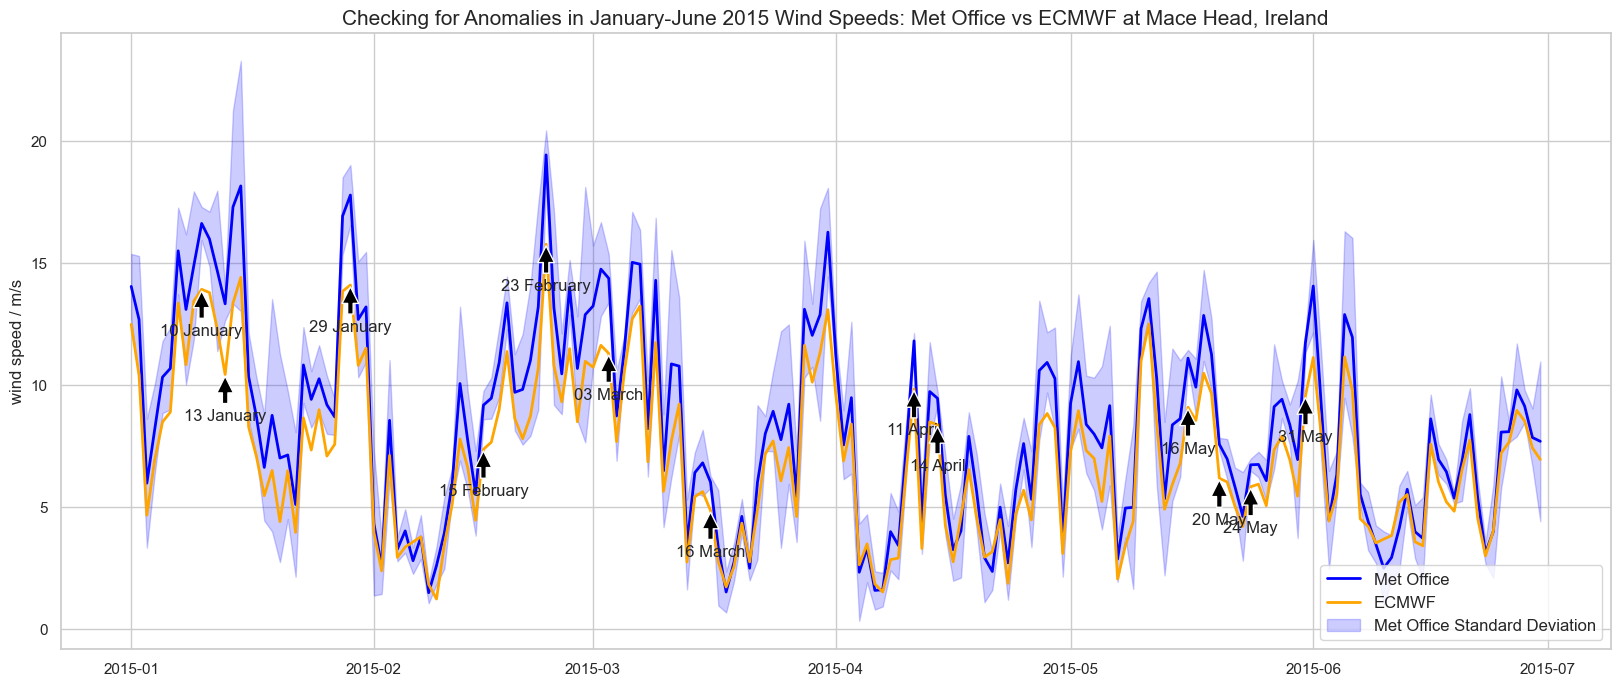

In [13]:
# Investing speed further - identifying anomalies
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='whitegrid')
sns.set_palette("colorblind")

# calculating daily averages
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)
met_daily.index = met_daily.index.to_timestamp()

ecmwf_daily = ecmwf_wind_speed.groupby(ecmwf_wind_speed.index.to_period('D')).mean().reset_index()
ecmwf_daily.set_index('time', inplace=True)

ax.plot(met_daily.index.get_level_values('time').values, met_daily["Wind_Speed"].values,
           label=(f"Met Office"), linewidth=2, color='blue')
ax.plot(ecmwf_daily.index.values, ecmwf_daily,
           label=(f"ECMWF"), linewidth=2, color='orange')

# calculating standard deviation
std_met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].std().reset_index()
std_met_daily.set_index('time', inplace=True)
met_daily = resampled_met_mhd.groupby(resampled_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)


# adding standard deviation shading
upper_met = met_daily["Wind_Speed"] + std_met_daily["Wind_Speed"]
lower_met = met_daily["Wind_Speed"] - std_met_daily["Wind_Speed"]
ax.fill_between(met_daily.index, lower_met, upper_met, color='blue', alpha=0.2, label="Met Office Standard Deviation")


# adding tolerance range based on 3 standard deviations
upper_range = met_daily["Wind_Speed"] + 3*(std_met_daily['Wind_Speed'])
lower_range = met_daily["Wind_Speed"] - 3*(std_met_daily['Wind_Speed'])

# calculating overall std for arrows
overall_std = met_daily["Wind_Speed"].std()

# adding labels to points outside tolerance range
for i in range(len(met_daily)):
    if ecmwf_daily.loc[ecmwf_daily.index[i]].item() >= upper_range.loc[ecmwf_daily.index[i]]:
        arrow_end = ecmwf_daily.iloc[i] + (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')

    elif ecmwf_daily.iloc[i].item() <= lower_range.iloc[i]:
        arrow_end = ecmwf_daily.iloc[i] - (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

plt.ylabel("wind speed / m/s")
plt.title(f"Checking for Anomalies in January-June 2015 Wind Speeds: Met Office vs ECMWF at Mace Head, Ireland", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [14]:
# calculating and printing various descriptive statistics - WIND DIRECTION
met_mean = resampled_met_mhd['Wind_Direction'].values.mean()
ecmwf_mean = ecmwf_wind_direction.mean()

met_median = np.median(resampled_met_mhd['Wind_Direction'].values)
ecmwf_median = np.median(ecmwf_wind_direction)

met_std = np.std(resampled_met_mhd['Wind_Direction'].values)
ecmwf_std = np.std(ecmwf_wind_direction)

met_range = resampled_met_mhd['Wind_Direction'].values.max() - resampled_met_mhd['Wind_Direction'].values.min()
ecmwf_range = ecmwf_wind_direction.max() - ecmwf_wind_direction.min()

print(f"Direction MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Direction MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Direction STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Direction RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Direction MEAN: Met Office = 220.304, ECMWF = 218.148
Direction MEDIAN: Met Office = 235.477, ECMWF = 236.287
Direction STANDARD DEVIATION: Met Office = 79.514, ECMWF = 88.221
Direction RANGE: Met Office = 345.203, ECMWF = 358.757


In [15]:
# calculating and printing various descriptive statistics - WIND SPEED
met_mean = resampled_met_mhd['Wind_Speed'].values.mean()
ecmwf_mean = ecmwf_wind_speed.mean()

met_median = np.median(resampled_met_mhd['Wind_Speed'].values)
ecmwf_median = np.median(ecmwf_wind_speed)

met_std = np.std(resampled_met_mhd['Wind_Speed'].values)
ecmwf_std = np.std(ecmwf_wind_speed)

met_range = resampled_met_mhd['Wind_Speed'].values.max() - resampled_met_mhd['Wind_Speed'].values.min()
ecmwf_range = ecmwf_wind_speed.max() - ecmwf_wind_speed.min()

print(f"Speed MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Speed MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Speed STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Speed RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Speed MEAN: Met Office = 8.389, ECMWF = 7.099
Speed MEDIAN: Met Office = 8.010, ECMWF = 6.783
Speed STANDARD DEVIATION: Met Office = 4.384, ECMWF = 3.585
Speed RANGE: Met Office = 22.330, ECMWF = 18.279


In [19]:
# calculating MAE, RMSE and MAPE based on mean values
# wind direction
mae_direction = np.mean(np.abs(resampled_met_mhd['Wind_Direction'].values - ecmwf_wind_direction.values))
rmse_direction = np.sqrt(np.mean((resampled_met_mhd['Wind_Direction'].values - ecmwf_wind_direction.values)**2))
mape_direction = np.mean(np.abs((resampled_met_mhd['Wind_Direction'].values - ecmwf_wind_direction.values) / resampled_met_mhd['Wind_Direction'].values)) * 100

# wind speed
mae_speed = np.mean(np.abs(resampled_met_mhd['Wind_Speed'].values - ecmwf_wind_speed.values))
rmse_speed = np.sqrt(np.mean((resampled_met_mhd['Wind_Speed'].values - ecmwf_wind_speed.values)**2))
mape_speed = np.mean(np.abs((met_mean - ecmwf_mean) / met_mean) * 100)


print(f"Direction MAE = {mae_direction:.3f}, RMSE = {rmse_direction:.3f}, MAPE = {mape_direction:.3f}%")
print(f"Speed MAE = {mae_speed:.3f}, RMSE = {rmse_speed:.3f}, MAPE = {mape_speed:.3f}%")

Direction MAE = 14.752, RMSE = 39.210, MAPE = 9.455%
Speed MAE = 1.438, RMSE = 1.745, MAPE = 15.375%


### Exploring One Month

In [24]:
# exploring March further because of identified anomalies
month = '06'
months_dict = {'01': 'January', '02': 'February', '03': 'March', '04': 'April', '05': 'May', '06': 'June'}
month_name = months_dict[month]

month_ecmwf_wind_speed, month_ecmwf_wind_direction, month_met_mhd = f.one_month(month, resampled_ecmwf_mhd, resampled_met_mhd)

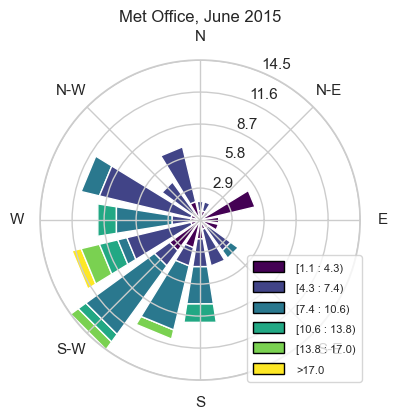

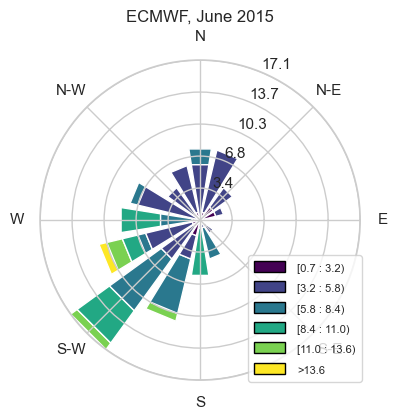

In [31]:
# Windrose plots
fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(month_met_mhd["Wind_Direction"], month_met_mhd["Wind_Speed"], 
       normed=True, opening=0.8, edgecolor='white', cmap=cm.viridis)
ax.set_legend(loc=4)
ax.set_title(f"Met Office, {month_name} 2015")
plt.show()

fig = plt.figure(figsize=(8,4))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(month_ecmwf_wind_direction, month_ecmwf_wind_speed, normed=True,
        opening=0.8, edgecolor='white', cmap=cm.viridis)
ax.set_legend(loc=4)
ax.set_title(f"ECMWF, {month_name} 2015")
plt.show()

Text(0.5, 0.98, 'Comparing ECMWF and Met Office Data, June 2015 at Mace Head, Ireland')

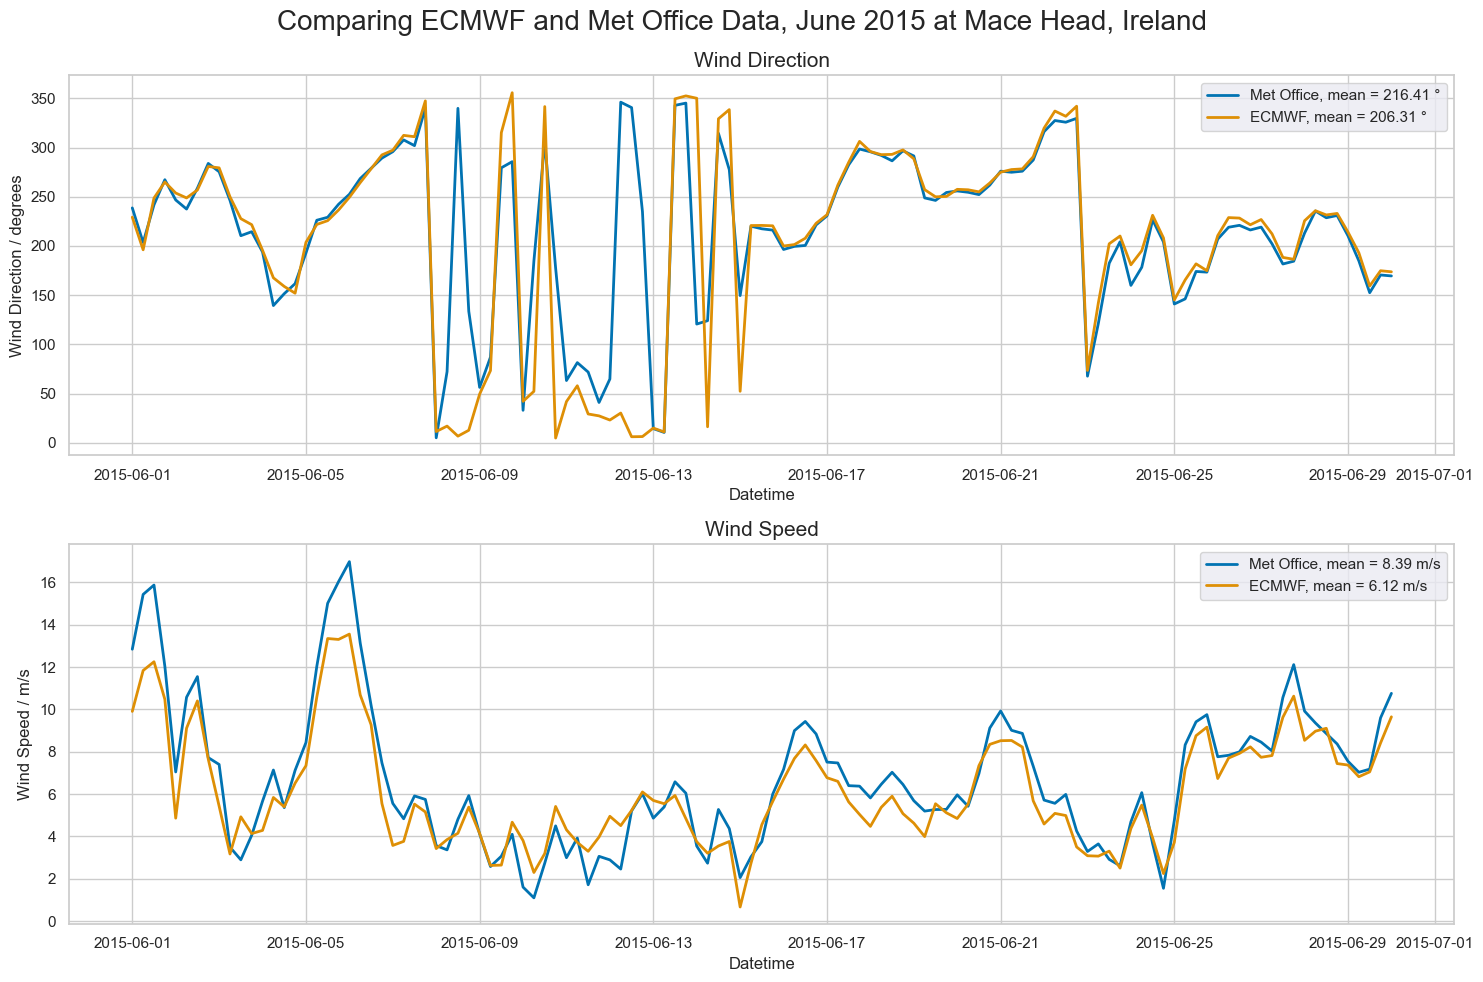

In [32]:
# plotting wind speeds and direction against time
fig, axs = plt.subplots(2,1, figsize=(15,10))
sns.set(style='darkgrid')
sns.set_palette("colorblind")

# plotting wind direction
axs[0].plot(month_met_mhd.index.get_level_values('time').values, month_met_mhd["Wind_Direction"].values,
           label=(f"Met Office, mean = {month_met_mhd['Wind_Direction'].values.mean():.2f} °"),
           linewidth=2)

axs[0].plot(month_ecmwf_wind_direction.index.values, month_ecmwf_wind_direction,
           label=(f"ECMWF, mean = {month_ecmwf_wind_direction.mean():.2f} °"),
           linewidth=2)

axs[0].set_xlabel("Datetime")
axs[0].set_ylabel("Wind Direction / degrees")
axs[0].legend()
axs[0].set_title("Wind Direction", fontsize=15)

# plotting wind speed
axs[1].plot(month_met_mhd.index.get_level_values('time').values, month_met_mhd["Wind_Speed"].values,
           label=(f"Met Office, mean = {met_mhd['Wind_Speed'].values.mean():.2f} m/s"),
           linewidth=2)

axs[1].plot(month_ecmwf_wind_speed.index.values, month_ecmwf_wind_speed,
           label=(f"ECMWF, mean = {month_ecmwf_wind_speed.mean():.2f} m/s"),
           linewidth=2)

axs[1].set_xlabel("Datetime")
axs[1].set_ylabel("Wind Speed / m/s")
axs[1].legend()
axs[1].set_title("Wind Speed", fontsize=15)

fig.set_tight_layout(True)
fig.suptitle(f"Comparing ECMWF and Met Office Data, {month_name} 2015 at Mace Head, Ireland", fontsize=20)

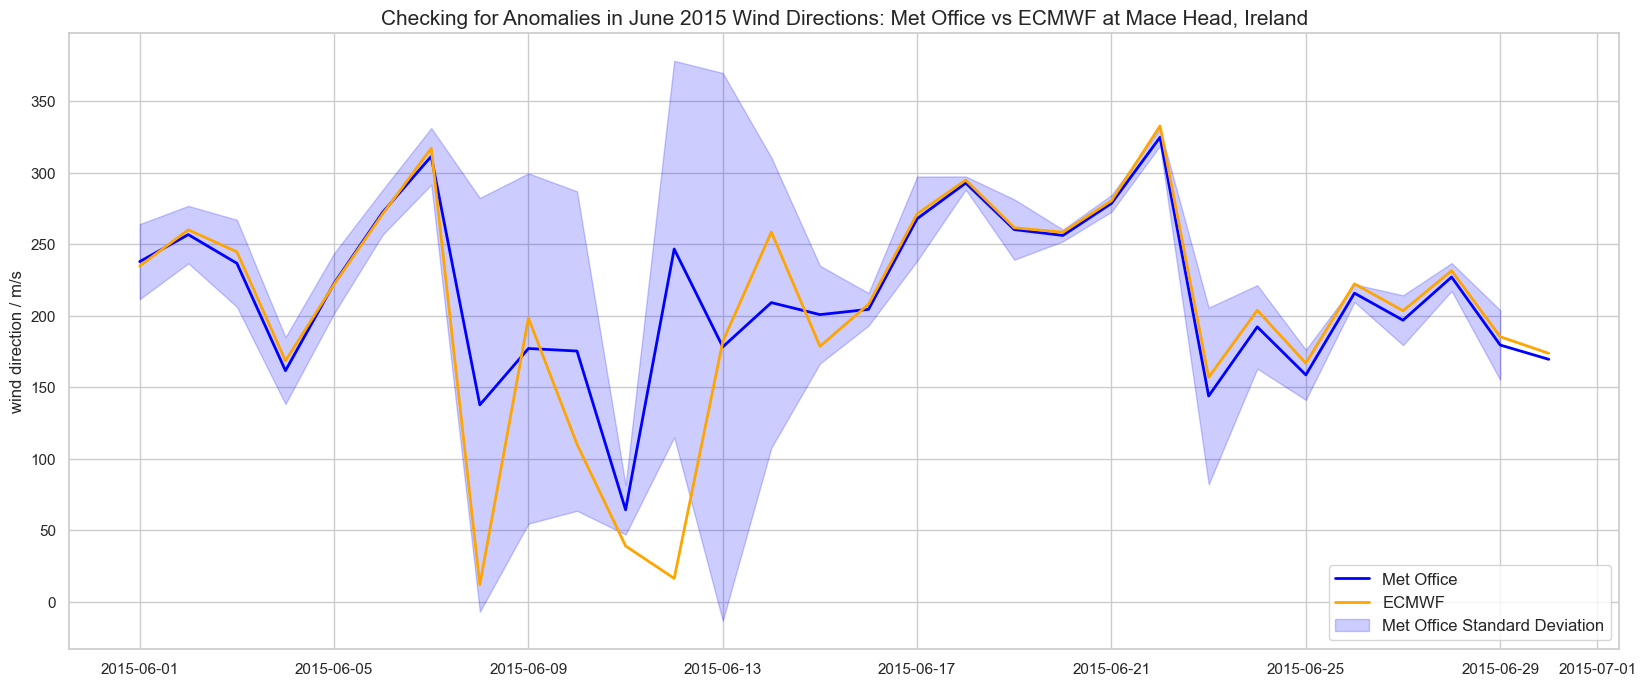

In [37]:
# Investing direction further - identifying anomalies
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='whitegrid')
sns.set_palette("colorblind")

# calculating daily averages
met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Direction"].mean().reset_index()
met_daily.set_index('time', inplace=True)
met_daily.index = met_daily.index.to_timestamp()
ecmwf_daily = month_ecmwf_wind_direction.groupby(month_ecmwf_wind_direction.index.to_period('D')).mean().reset_index()
ecmwf_daily.set_index('time', inplace=True)

ax.plot(met_daily.index.get_level_values('time').values, met_daily["Wind_Direction"].values,
           label=(f"Met Office"), linewidth=2, color='blue')
ax.plot(ecmwf_daily.index.values, ecmwf_daily,
           label=(f"ECMWF"), linewidth=2, color='orange')

# calculating standard deviation
std_met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Direction"].std().reset_index()
std_met_daily.set_index('time', inplace=True)
met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Direction"].mean().reset_index()
met_daily.set_index('time', inplace=True)


# adding standard deviation shading
upper_met = met_daily["Wind_Direction"] + std_met_daily["Wind_Direction"]
lower_met = met_daily["Wind_Direction"] - std_met_daily["Wind_Direction"]
ax.fill_between(met_daily.index, lower_met, upper_met, color='blue', alpha=0.2, label="Met Office Standard Deviation")


# adding tolerance range based on 3 standard deviations
upper_range = met_daily["Wind_Direction"] + 3*(std_met_daily['Wind_Direction'])
lower_range = met_daily["Wind_Direction"] - 3*(std_met_daily['Wind_Direction'])

# calculating overall std for arrows
overall_std = met_daily["Wind_Direction"].std()

# adding labels to points outside tolerance range
for i in range(len(met_daily)):
    if ecmwf_daily.loc[ecmwf_daily.index[i]].item() >= upper_range.loc[ecmwf_daily.index[i]]:
        arrow_end = ecmwf_daily.iloc[i] + (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')

    elif ecmwf_daily.iloc[i].item() <= lower_range.iloc[i]:
        arrow_end = ecmwf_daily.iloc[i] - (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

plt.ylabel("wind direction / m/s")
plt.title(f"Checking for Anomalies in {month_name} 2015 Wind Directions: Met Office vs ECMWF at Mace Head, Ireland", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.show()

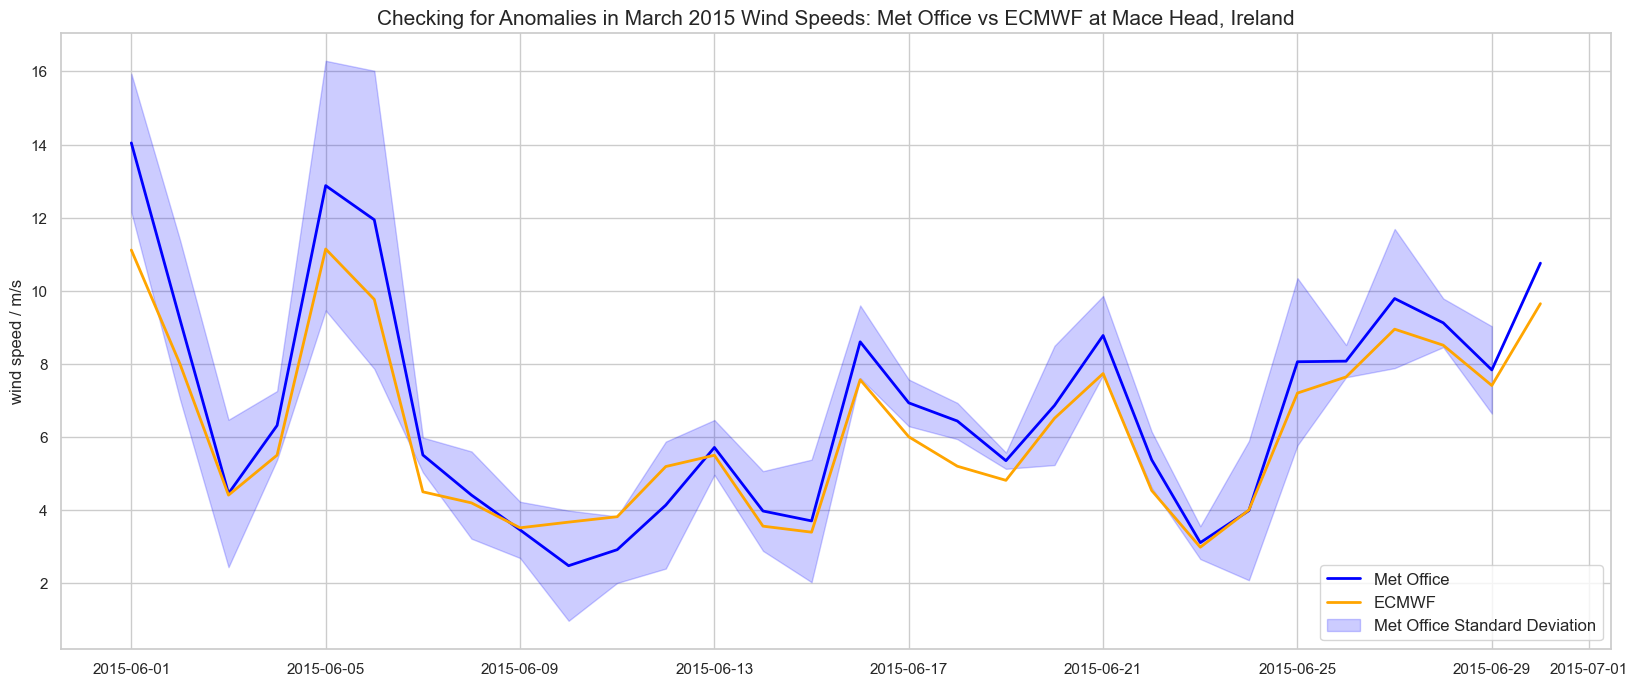

In [39]:
# Investing speed further - identifying anomalies
fig, ax = plt.subplots(figsize=(20,8))
sns.set(style='whitegrid')
sns.set_palette("colorblind")

# calculating daily averages
met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)
met_daily.index = met_daily.index.to_timestamp()
ecmwf_daily = month_ecmwf_wind_speed.groupby(month_ecmwf_wind_speed.index.to_period('D')).mean().reset_index()
ecmwf_daily.set_index('time', inplace=True)

ax.plot(met_daily.index.get_level_values('time').values, met_daily["Wind_Speed"].values,
           label=(f"Met Office"), linewidth=2, color='blue')
ax.plot(ecmwf_daily.index.values, ecmwf_daily,
           label=(f"ECMWF"), linewidth=2, color='orange')

# calculating standard deviation
std_met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Speed"].std().reset_index()
std_met_daily.set_index('time', inplace=True)
met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D'))["Wind_Speed"].mean().reset_index()
met_daily.set_index('time', inplace=True)


# adding standard deviation shading
upper_met = met_daily["Wind_Speed"] + std_met_daily["Wind_Speed"]
lower_met = met_daily["Wind_Speed"] - std_met_daily["Wind_Speed"]
ax.fill_between(met_daily.index, lower_met, upper_met, color='blue', alpha=0.2, label="Met Office Standard Deviation")


# adding tolerance range based on 3 standard deviations
upper_range = met_daily["Wind_Speed"] + 3*(std_met_daily['Wind_Speed'])
lower_range = met_daily["Wind_Speed"] - 3*(std_met_daily['Wind_Speed'])

# calculating overall std for arrows
overall_std = met_daily["Wind_Speed"].std()

# adding labels to points outside tolerance range
for i in range(len(met_daily)):
    if ecmwf_daily.loc[ecmwf_daily.index[i]].item() >= upper_range.loc[ecmwf_daily.index[i]]:
        arrow_end = ecmwf_daily.iloc[i] + (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')

    elif ecmwf_daily.iloc[i].item() <= lower_range.iloc[i]:
        arrow_end = ecmwf_daily.iloc[i] - (overall_std*0.5)
        ax.annotate(ecmwf_daily.index[i].strftime('%d %B'), 
                    xy=(ecmwf_daily.index[i], ecmwf_daily.iloc[i]), 
                    xytext=(ecmwf_daily.index[i], arrow_end), 
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    horizontalalignment='center', verticalalignment='bottom')
        

plt.ylabel("wind speed / m/s")
plt.title(f"Checking for Anomalies in March 2015 Wind Speeds: Met Office vs ECMWF at Mace Head, Ireland", fontsize=15)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [40]:
# calculating and printing various descriptive statistics - WIND DIRECTION
met_mean = month_met_mhd['Wind_Direction'].values.mean()
ecmwf_mean = month_ecmwf_wind_direction.mean()

met_median = np.median(month_met_mhd['Wind_Direction'].values)
ecmwf_median = np.median(month_ecmwf_wind_direction)

met_std = np.std(month_met_mhd['Wind_Direction'].values)
ecmwf_std = np.std(month_ecmwf_wind_direction)

met_range = month_met_mhd['Wind_Direction'].values.max() - month_met_mhd['Wind_Direction'].values.min()
ecmwf_range = month_ecmwf_wind_direction.max() - month_ecmwf_wind_direction.min()

print(f"Direction MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Direction MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Direction STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Direction RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Direction MEAN: Met Office = 216.410, ECMWF = 206.309
Direction MEDIAN: Met Office = 226.137, ECMWF = 225.712
Direction STANDARD DEVIATION: Met Office = 79.748, ECMWF = 98.197
Direction RANGE: Met Office = 340.958, ECMWF = 350.808


In [41]:
# calculating and printing various descriptive statistics - WIND SPEED
met_mean = month_met_mhd['Wind_Speed'].values.mean()
ecmwf_mean = month_ecmwf_wind_speed.mean()

met_median = np.median(month_met_mhd['Wind_Speed'].values)
ecmwf_median = np.median(month_ecmwf_wind_speed)

met_std = np.std(month_met_mhd['Wind_Speed'].values)
ecmwf_std = np.std(month_ecmwf_wind_speed)

met_range = month_met_mhd['Wind_Speed'].values.max() - month_met_mhd['Wind_Speed'].values.min()
ecmwf_range = month_ecmwf_wind_speed.max() - month_ecmwf_wind_speed.min()

print(f"Speed MEAN: Met Office = {met_mean:.3f}, ECMWF = {ecmwf_mean:.3f}")
print(f"Speed MEDIAN: Met Office = {met_median:.3f}, ECMWF = {ecmwf_median:.3f}")
print(f"Speed STANDARD DEVIATION: Met Office = {met_std:.3f}, ECMWF = {ecmwf_std:.3f}")
print(f"Speed RANGE: Met Office = {met_range:.3f}, ECMWF = {ecmwf_range:.3f}")

Speed MEAN: Met Office = 6.710, ECMWF = 6.116
Speed MEDIAN: Met Office = 6.041, ECMWF = 5.525
Speed STANDARD DEVIATION: Met Office = 3.292, ECMWF = 2.604
Speed RANGE: Met Office = 15.879, ECMWF = 12.889


In [42]:
# resampling monthly data to daily averages

# picking out month of interest
met_daily = month_met_mhd.groupby(month_met_mhd.index.to_period('D')).mean()
ecmwf_daily_speed = month_ecmwf_wind_speed.groupby(month_ecmwf_wind_speed.index.to_period('D')).mean()
ecmwf_daily_direction = month_ecmwf_wind_direction.groupby(month_ecmwf_wind_direction.index.to_period('D')).mean()

met_daily, ecmwf_daily_speed, ecmwf_daily_direction = met_daily.dropna(), ecmwf_daily_speed.dropna(), ecmwf_daily_direction.dropna()

In [43]:
# calculating MAE, RMSE and MAPE for comparing the two datasets
# wind direction
mae_direction = np.mean(np.abs(met_daily['Wind_Direction'].values - ecmwf_daily_direction.values))
rmse_direction = np.sqrt(np.mean((met_daily['Wind_Direction'].values - ecmwf_daily_direction.values)**2))
mape_direction = np.mean(np.abs((met_daily['Wind_Direction'].values - ecmwf_daily_direction.values) / met_daily['Wind_Direction'].values)) * 100

# wind speed
mae_speed = np.mean(np.abs(met_daily['Wind_Speed'].values - ecmwf_daily_speed.values))
rmse_speed = np.sqrt(np.mean((met_daily['Wind_Speed'].values - ecmwf_daily_speed.values)**2))
mape_speed = np.mean(np.abs((met_daily['Wind_Speed'].values - ecmwf_daily_speed.values) / met_daily['Wind_Speed'].values)) * 100

print(f"Direction MAE = {mae_direction:.3f}, RMSE = {rmse_direction:.3f}, MAPE = {mape_direction:.3f}%")
print(f"Speed MAE = {mae_speed:.3f}, RMSE = {rmse_speed:.3f}, MAPE = {mape_speed:.3f}%")

Direction MAE = 21.806, RMSE = 50.933, MAPE = 12.163%
Speed MAE = 0.822, RMSE = 1.037, MAPE = 12.321%
